# Captain Cook: the fabulous recipes explorator



Objectives:

- [X] Create our own JSON map to plot informations about the recipes by region more specifically
- [Pending] Make the map more interactive and correct the colormap issue
- [Pending] Finish the ingredients list cleaning
- [X] Use statistical properties of the English language or Levenshtein distance
- [Pending] Create a user friendly recipe finder 


Bonus:

- Try to compute missing nutritional informations
- Find meaningful substitutions for ingredients

In [1]:
# Basic imports
import re
import os.path
import numpy as np
import scipy as sp
import pandas as pd

# Map-related imports
import json
import branca
import folium
from pandas.io.json import json_normalize
from IPython.core.display import display, HTML

# Plot-related imports
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets.embed import embed_minimal_html

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# General parameters
%matplotlib inline
plt.style.use('seaborn')#switch to seaborn style
plt.rcParams["figure.figsize"] = [16,10]

DATA_FOLDER = './data/'

# 1. Data Loading
  
The Data has been fetched and cleaned with `BASH`scripts, please look in the *dataCleaning* section to understand how this was achieved.  

**Home made fetched dataset:**

In [3]:
# Importing ingredients to Pandas DF
allrecipes_df = pd.read_csv(DATA_FOLDER + 'allrecipes.csv', sep='\t',  header=None, encoding = "utf-8")
allrecipes_df.columns = ['ID', 'Region', 'Title', 'Ingredients', 'kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']

# Bug?? need to convert into numeric somes, TODO EFFICIENT WAY TO DO THIS???
allrecipes_df['kcal'] = pd.to_numeric(allrecipes_df['kcal'], errors='coerce')
allrecipes_df['carb'] = pd.to_numeric(allrecipes_df['carb'], errors='coerce') / 1000.0 # convert to g
allrecipes_df['fat'] = pd.to_numeric(allrecipes_df['fat'], errors='coerce') / 1000.0 # convert to g
allrecipes_df['protein'] = pd.to_numeric(allrecipes_df['protein'], errors='coerce')
allrecipes_df['sodium'] = pd.to_numeric(allrecipes_df['sodium'], errors='coerce') / 1000.0
allrecipes_df['cholesterol'] = pd.to_numeric(allrecipes_df['cholesterol'], errors='coerce')

# Remove any rows which isn't properly formatted
allrecipes_df = allrecipes_df.dropna()

# Remove any duplicated lines
allrecipes_df = allrecipes_df.drop_duplicates().set_index('ID')

# Printing
allrecipes_df.head(5)

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,2 cups persimmon pulp |2 eggs |1 cup white sug...,278.0,53.9,3.8,7.8,0.224,35.0
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,1 cup all-purpose flour |2 tablespoons cornsta...,409.0,43.0,18.8,17.3,0.407,54.0
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,8 bratwurst |2 (12 fluid ounce) cans or bottle...,377.0,12.8,27.4,13.8,1.046,69.0
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,2/3 cup hot pepper sauce (such as Frank&#39;s ...,104.0,0.4,11.6,0.2,0.576,31.0
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,"1 cup butter, softened |1 1/2 cups brown sugar...",140.0,14.9,8.7,1.5,0.076,22.0


In [4]:
# Importing descriptions to Pandas DF
allrecipes_desc_df = pd.read_csv(DATA_FOLDER + 'allrecipes_desc.csv', sep='£',  header=None, encoding = "utf-8",  engine='python')
allrecipes_desc_df.columns = ['ID', 'Description']

# Remove any duplicated lines
allrecipes_desc_df = allrecipes_desc_df.drop_duplicates().set_index('ID')

allrecipes_desc_df.head(5)

,Description
ID,
b9705d990df6857f20756fc996a54b63,Preheat the oven to 350 degrees F (175 degree...
4658708d644d7b446d843fed5ddf60c4,"To make beer batter: In a large bowl, combine..."
beed004e2a1772ba0db9da913f54122e,"Place bratwurst, beer, onion, and ketchup in ..."
96353c72421bd74096277c6cf8b17097,"Combine the hot sauce, butter, vinegar, Worce..."
ee659a6a5e69834b60744cc3e103729e,Preheat oven to 350 degrees F (175 degrees C)...


In [5]:
print("Number of recipes:", len(allrecipes_df.index.unique()))

Number of recipes: 15894


**Provided Dataset**

This dataset was provided with the assignment and cleaned with the provided `Perl` scripts. 

Thanks to the scripts, we obtain two datasets:

1. `cleaned_ing.csv` contains the list of ingredients for each recipe,
2. `cleaned_nutri.csv` contains the corresponding nutritional values.

Our objective is to merge these two sets to obtain a unique set with all useful informations.

In [6]:
# Importing ingredients to Pandas DF
ing_df = pd.read_csv(DATA_FOLDER + 'cleaned_ing.csv', sep='\t',  header=None, encoding = "utf-8")
ing_df.columns = ['ID', 'Title', 'Ingredients']

# Importing nutritional values to Pandas DF
nutri_df = pd.read_csv(DATA_FOLDER + 'cleaned_nutri.csv', sep='\t',  header=None, encoding = "utf-8")
nutri_df.columns = ['ID', 'kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']

# Merging
ing_df = ing_df.set_index('ID')
nutri_df = nutri_df.set_index('ID')
provided_df = ing_df.merge(nutri_df, on='ID', how='inner')

# Drop NaNs and duplicate lines
provided_df = provided_df.dropna().drop_duplicates()

provided_df.head()

,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,
38e1b80017526d6e59ed3f986c35a43a,T.G.I. Friday's Jack Daniels Sauce Recipe #10265,1 teaspoon onion powder|1 tablespoon Tabasco s...,?,?,?,?,?,?
a3636a4dab434fe21fbcdceba7d6fcf2,Simple Peanut Squash Recipe,1 butternut squash|2 tablespoons brown sugar|1...,536,86.4,23.6,6.5,483,61
117f3c214e9de550a157ce5ee1f1cceb,Hash Brown Breakfast Casserole Recipe,"1 lb ground sausage (""hot"" or ""sage"" flavored)...",660.4,24.7,47.3,32.5,1248.0,251.6
fde8f280a690fb8bc77c10a7193db08b,Basic Homemade Country Sausage Recipe,2 pounds lean pork|1/2 pound pork fatback|3 te...,?,?,?,?,?,?
714df642f50b9ae489d285e16b59bf7b,Spinach Frittata Recipe,1 cup fresh spinach|2 egg whites|1 egg yolk|1/...,?,?,?,?,?,?


We can observe that some nutritional values are missing, which can be solved either by removing the lines or by trying to calculate these values from the given ingredients.

As trying to calculate the values from ingredients with different units (i.e. grams, cups, tbsp, etc) requires a set of informations that we do not have, we decided to leave these lines as they are for now. 

In [7]:
# Bug?? need to convert into numeric somes, TODO EFFICIENT WAY TO DO THIS???
provided_df['kcal'] = pd.to_numeric(provided_df['kcal'], errors='coerce')
provided_df['carb'] = pd.to_numeric(provided_df['carb'], errors='coerce')
provided_df['fat'] = pd.to_numeric(provided_df['fat'], errors='coerce')
provided_df['protein'] = pd.to_numeric(provided_df['protein'], errors='coerce')
provided_df['sodium'] = pd.to_numeric(provided_df['sodium'], errors='coerce')
provided_df['cholesterol'] = pd.to_numeric(provided_df['cholesterol'], errors='coerce')

# Insert Region column to match the other DF
provided_df.insert(loc=1, column='Region', value=np.nan)
provided_df.head(5)

,Title,Region,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
38e1b80017526d6e59ed3f986c35a43a,T.G.I. Friday's Jack Daniels Sauce Recipe #10265,NaN,1 teaspoon onion powder|1 tablespoon Tabasco s...,NaN,NaN,NaN,NaN,NaN,NaN
a3636a4dab434fe21fbcdceba7d6fcf2,Simple Peanut Squash Recipe,NaN,1 butternut squash|2 tablespoons brown sugar|1...,536.0,86.4,23.6,6.5,483.0,61.0
117f3c214e9de550a157ce5ee1f1cceb,Hash Brown Breakfast Casserole Recipe,NaN,"1 lb ground sausage (""hot"" or ""sage"" flavored)...",660.4,24.7,47.3,32.5,1248.0,251.6
fde8f280a690fb8bc77c10a7193db08b,Basic Homemade Country Sausage Recipe,NaN,2 pounds lean pork|1/2 pound pork fatback|3 te...,NaN,NaN,NaN,NaN,NaN,NaN
714df642f50b9ae489d285e16b59bf7b,Spinach Frittata Recipe,NaN,1 cup fresh spinach|2 egg whites|1 egg yolk|1/...,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Number of recipes:", len(provided_df.index.unique()))

Number of recipes: 31376


In [9]:
# Concatenate the 2 DF and drop any duplicated lines, it is possible since some data come from the same website!
recipes_df = allrecipes_df.append(provided_df, sort=False).drop_duplicates()
recipes_df['Region'] = recipes_df['Region'].astype('category')

recipes_df.head()

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol
ID,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,2 cups persimmon pulp |2 eggs |1 cup white sug...,278.0,53.9,3.8,7.8,0.224,35.0
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,1 cup all-purpose flour |2 tablespoons cornsta...,409.0,43.0,18.8,17.3,0.407,54.0
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,8 bratwurst |2 (12 fluid ounce) cans or bottle...,377.0,12.8,27.4,13.8,1.046,69.0
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,2/3 cup hot pepper sauce (such as Frank&#39;s ...,104.0,0.4,11.6,0.2,0.576,31.0
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,"1 cup butter, softened |1 1/2 cups brown sugar...",140.0,14.9,8.7,1.5,0.076,22.0


In [10]:
print("Number of total recipes:", len(recipes_df.index.unique()))

Number of total recipes: 46999


In [11]:
len(recipes_df[recipes_df['Region']=='italian'])/365

6.841095890410959

We see that the total number of recipes is enough to eat italian recipes everyday for almost 7 years!!  
We can save this DataFrame to be use later on.

In [12]:
recipes_df.to_csv(DATA_FOLDER + 'recipes_df.csv', sep='\t', encoding='utf-8')

# 2. Ingredient parsing
The cleaning is presented in `DataCleaning.ipynb`, here we use directly the result which is a list of good ingredient that can be matched in the recipes and are relevant for any statistical analysis

In [13]:
# Load csv file 'hand' cleaned
with open(DATA_FOLDER + 'cleaned_list') as f:
    ing_list = f.read().splitlines()
    
# Load the dictionnary that correct the name mispelled
ing_dict = np.load(DATA_FOLDER + 'ing_dict.npy').item()

In [14]:
# USEFUL
recipes_copy = recipes_df.copy()
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].str.lower()

# Remove non alphabetic values expect of '|' which is the seperating char
recipes_copy['Ingredients'] = recipes_copy['Ingredients'].str.replace('[^a-zA-Z ]+', ' ')

In [15]:
# This step is needed to clean the dataset ingredient!
# Function that apply the cleaning dictionnary on every word in ingredients column for each recipes
def matcher(k):
    x = (i for i in ing_dict if i in k.split(' '))
    return '|'.join(map(ing_dict.get, x))

# Cleaned!!!
recipes_copy['Cleaned_Ing'] = recipes_copy['Ingredients'].map(matcher)
recipes_copy

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol,Cleaned_Ing
ID,,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,cups persimmon pulp eggs cup white sugar...,278.0,53.9,3.8,7.8,0.224,35.0,butter|flour|milk|eggs|persimmon
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,cup all purpose flour tablespoons cornstar...,409.0,43.0,18.8,17.3,0.407,54.0,salt|pepper|flour|powder|cumin|lime|corn|mayon...
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,bratwurst fluid ounce cans or bottles b...,377.0,12.8,27.4,13.8,1.046,69.0,onion|beef
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,cup hot pepper sauce such as frank s redhot...,104.0,0.4,11.6,0.2,0.576,31.0,salt|pepper|butter|powder|vinegar|worcestershire
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,cup butter softened cups brown sugar ...,140.0,14.9,8.7,1.5,0.076,22.0,salt|butter|flour|powder|milk|eggs|vanilla|cho...
1afe62458129f741d989b89d6ae8d08c,us,Kendra's Maid-Rite Sandwiches,pounds ground beef chopped onion cup ket...,244.0,27.0,8.9,13.4,0.483,34.0,salt|onion|vinegar|beef|worcestershire|hamburger
7b93a05f2c4a9ff967957f62fe5c6622,us,Amish White Bread,cups warm water degrees f degrees c cu...,168.0,30.7,2.9,4.4,0.147,0.0,salt|flour|water|bread|yeast
fb0673097182df2dd7f7355b0e41693a,us,Buffalo Chicken Dip,ounce cans chunk chicken drained oun...,284.0,8.6,22.6,11.1,0.552,54.0,pepper|chicken|cream|celery|cheddar|cracker
1eaa22e1674b18dfbd30ec384931e9b1,us,Roast Sticky Chicken-Rotisserie Style,teaspoons salt teaspoons paprika teaspoo...,586.0,3.7,34.3,61.7,1.351,194.0,salt|pepper|onion|powder|onion|chicken


----
**The ingredient list is now perfectly cleaned: we can do some neat analysis on it**

In [16]:
# Expand the cleaned ingredient for each recipes
matrix = recipes_copy['Cleaned_Ing'].str.get_dummies('|')
matrix.head()

,achiote,acini,adobo,adzuki,agar,aioli,ajies,ajinomoto,alcohol,alfalfa,...,yoplait,yucca,zapallo,zape,zesty,zinfandel,ziploc,ziti,zucchini,zwieback
ID,,,,,,,,,,,,,,,,,,,,,
b9705d990df6857f20756fc996a54b63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4658708d644d7b446d843fed5ddf60c4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
beed004e2a1772ba0db9da913f54122e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96353c72421bd74096277c6cf8b17097,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ee659a6a5e69834b60744cc3e103729e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Convert to numpy array for mathematic manipulations
X = matrix.values

# Compute the adjacency of the ingredient Graphs
# Indeed, since each values belong to the set {0,1}
# we get a matrix which corresponds to the number of link
# between two ingredients, it is define by the number at a given line - column
# TODO explanation

adjacency = X.T @ X

In [18]:
# Graph Plotting

# TODO: that would be nice https://www.curiousgnu.com/reddit-comments



-----
**Test with Holoviews**

In [19]:
df = pd.DataFrame(data=adjacency,    # values
...               index=matrix.columns,    # 1st column as index
...               columns=matrix.columns)  # 1st row as the column names

df = df.unstack().to_frame().reset_index().drop_duplicates()
df.columns = ['src', 'trg', 'number']
df = df.nlargest(200, columns='number')
df

NameError: name 'adjacency' is not defined

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
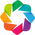

NameError: name 'df' is not defined

In [20]:
#import numpy as np
import pandas as pd
import holoviews as hv
hv.extension('bokeh')
%output fig='html' size=300

%opts Chord [label_index='index' color_index='src' edge_color_index='src'] 
%opts Chord (cmap='Category20' edge_cmap='Category20')
hv.Chord(df)

---

In [21]:
recipes_copy.head()

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol,Cleaned_Ing
ID,,,,,,,,,,
b9705d990df6857f20756fc996a54b63,us,Traditional Indiana Persimmon Pudding,cups persimmon pulp eggs cup white sugar...,278.0,53.9,3.8,7.8,0.224,35.0,butter|flour|milk|eggs|persimmon
4658708d644d7b446d843fed5ddf60c4,us,Fish Tacos,cup all purpose flour tablespoons cornstar...,409.0,43.0,18.8,17.3,0.407,54.0,salt|pepper|flour|powder|cumin|lime|corn|mayon...
beed004e2a1772ba0db9da913f54122e,us,Wisconsin Slow Cooker Brats,bratwurst fluid ounce cans or bottles b...,377.0,12.8,27.4,13.8,1.046,69.0,onion|beef
96353c72421bd74096277c6cf8b17097,us,Buffalo Chicken Wing Sauce,cup hot pepper sauce such as frank s redhot...,104.0,0.4,11.6,0.2,0.576,31.0,salt|pepper|butter|powder|vinegar|worcestershire
ee659a6a5e69834b60744cc3e103729e,us,Minnesota's Favorite Cookie,cup butter softened cups brown sugar ...,140.0,14.9,8.7,1.5,0.076,22.0,salt|butter|flour|powder|milk|eggs|vanilla|cho...


In [22]:
# Count occurences
ing_ds = recipes_copy['Ingredients'].str.split(" ", expand=True) \
                                    .stack() \
                                    .map(ing_dict) \
                                    .value_counts()  \
                                    .to_frame()  \
                                    .reset_index()

# TODO THIS SHOULD BE MOVE BELOW, IT IS AN ANALYSIS -> Quite useless but hey :P
ing_ds.head()

,index,0
0,pepper,27988
1,salt,26868
2,onion,19281
3,butter,15320
4,flour,13543


**Try visualization of WordCloud**

In [22]:
ing_ds_region = recipes_copy

regions = ing_ds_region['Region'].unique().dropna()

top_regions = ing_ds_region.groupby('Region').count().sort_values(by='Title', ascending=False).head(5)\
.index.tolist()

top_regions

['us', 'italian', 'mexican', 'canadian', 'indian']

In [23]:
ingredients_per_region_list = []
for region in regions:
    ing_ds_region_2 = ing_ds_region[ing_ds_region['Region'] == region]['Ingredients'].str.split(" ", expand=True) \
                                                                    .stack() \
                                                                    .map(ing_dict) \
                                                                    .value_counts()  \
                                                                    .to_frame()  \
                                                                    .reset_index()
    ing_ds_region_2['Region'] = region
    ingredients_per_region_list.append(ing_ds_region_2)

ingredients_per_region = pd.concat(ingredients_per_region_list)
ingredients_per_region = ingredients_per_region.set_index('Region')
ingredients_per_region.columns = ['Ingredient', 'Count']

(1136, 1600, 4)


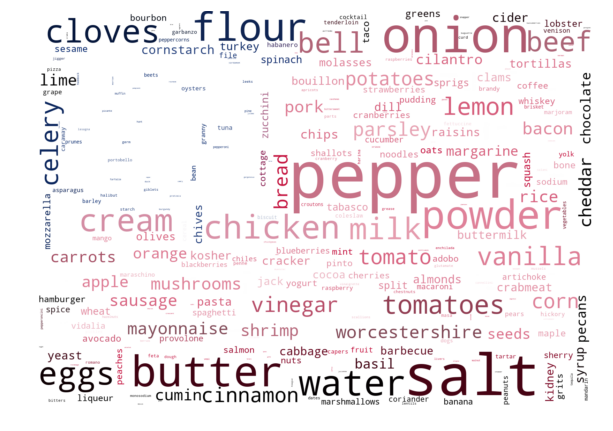

(1000, 1500, 3)


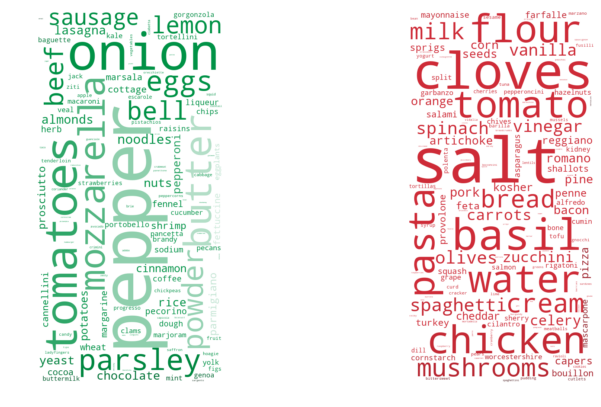

(600, 800, 4)


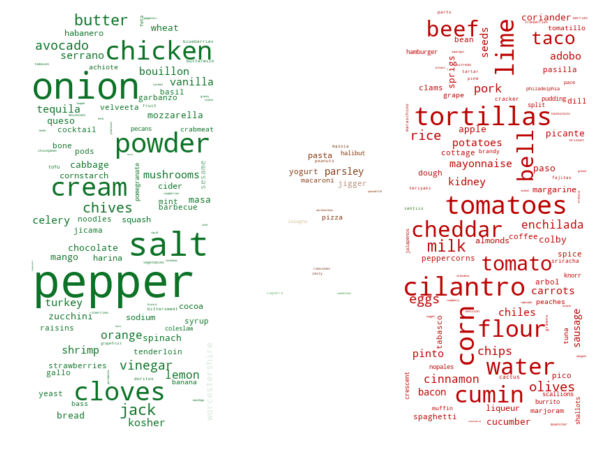

(456, 840, 3)


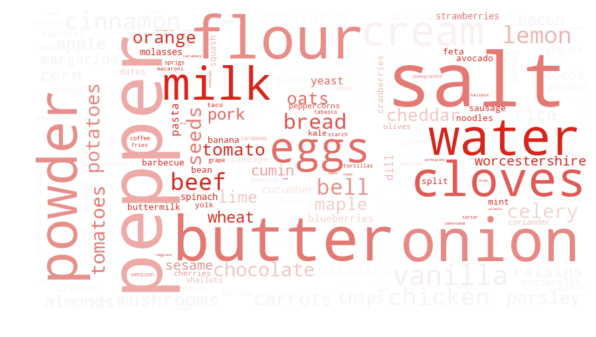

(1333, 2000, 4)


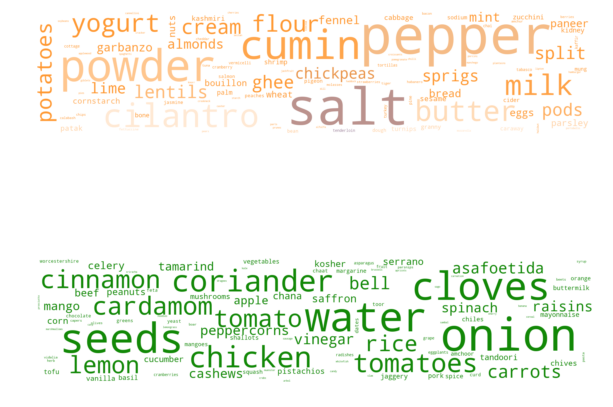

In [25]:
def get_region_ing(region):
    ingredients = ingredients_per_region[ingredients_per_region.index == region]
    return dict(zip(ingredients['Ingredient'], ingredients['Count']))
    

for region in top_regions:
    ing_list = get_region_ing(region)
    # Generate a word cloud image
    mask = np.array(Image.open("Masks/"+region+".png"))

    wordcloud = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask)\
    .generate_from_frequencies(ing_list)

    print(mask.shape)
    # create coloring from image
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    plt.axis("off")

    # store to file
    plt.savefig("./website/freelancer-theme/img/Flags/"+region+"_ing.svg", format="svg")

    plt.show()


**Try visualization with holoviews**

In [27]:
for region in regions:
    ingredients_per_region['Region']

,Ingredient,Count
Region,,
us,pepper,3123
us,salt,2336
us,onion,1708
us,butter,1213
us,powder,1113
us,flour,1081
us,water,910
us,chicken,729
us,cloves,714


**Try visualization on network**

In [86]:
# plot with plotly
import plotly.plotly as py
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

print(__version__)# requires version >= 1.9.0

import plotly.graph_objs as go

import networkx as nx

G=nx.from_numpy_array(adjacency)

# pos=nx.get_node_attributes(G,'pos')

pos = nx.random_layout(G)

dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

p=nx.single_source_shortest_path_length(G,ncenter)

edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in G.edges():
    x0, y0 = G.node[edge[0]]['pos']
    x1, y1 = G.node[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for node in G.nodes():
    x, y = G.node[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    
for node, adjacencies in enumerate(G.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_trace['marker']['size']+=1
    node_info = '# of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])
    
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Network graph made with Python',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="Python code: <a href='https://plot.ly/ipython-notebooks/network-graphs/'> https://plot.ly/ipython-notebooks/network-graphs/</a>",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

plot(fig, filename='networkx')

3.4.2


KeyError: 'pos'

In [38]:
plt.xscale("log")
plt.xlabel('Ingredient # in order')
plt.ylabel('Frequency')
plt.title('Distribution of the ingredient counts')
plt.show()

'plt.xscale("log")\nplt.xlabel(\'Ingredient # in order\')\nplt.ylabel(\'Frequency\')\nplt.title(\'Distribution of the ingredient counts\')\nplt.show()'

# 3. Cooking time study-case

In this part we would like to analyze the cooking time of the recipes to be able to classify which regions have the highest and lowest cooking time.

In [22]:
# Extract all timing from recipes
timing_df = allrecipes_desc_df['Description'].str.extractall(r'(\d+) minutes|(\d+) hour|hours')
timing_df.columns = ['minutes', 'hours']

#Replace Nan by 0 and switch to int type
timing_df = timing_df.fillna(0).astype(int)

#Sum the number of minutes to get the recipe time
timing_df['Time (min)'] = timing_df['minutes']+timing_df['hours']*60

timing_df.head()

minutes  hours  Time (min)
ID                               match                            
b9705d990df6857f20756fc996a54b63 0            0      2         120
                                 1           15      0          15
beed004e2a1772ba0db9da913f54122e 0            0      4         240
                                 1            5      0           5
ee659a6a5e69834b60744cc3e103729e 0           12      0          12

In [23]:
# Sum the total amount of time for each recipe
time_recipe = timing_df.groupby('ID').agg('sum')
time_recipe = time_recipe.drop(['minutes','hours'], axis=1)

time_recipe.head()

,Time (min)
ID,
00035a69b44a9dd1f88f2bb5faced261,90
000d31e632cab9e6902f05196354a007,660
0015417d2473d92a56da28883a27aff3,120
001cf1a5a0d1914f958cb2c823df6121,8
001f5efe07f4c72b4aaf846ec7616aba,13


# 4. Merging
Finally, we can merge everything to a single DataFrame to use it for Visualization

In [24]:
# Merging Cooking Time
cleaned_df = recipes_df.merge(time_recipe, on='ID', how='left')

# Cleaning ingredient and ingredient substition
# This is not yet implemented but we are close to achieve this

cleaned_df.sample(5)

,Region,Title,Ingredients,kcal,carb,fat,protein,sodium,cholesterol,Time (min)
ID,,,,,,,,,,
6ff392bc7f3dcd2f8dce637339f10c5e,us,Slow Cooker Carolina BBQ,1 (5 pound) bone-in pork shoulder roast |1 tab...,293.0,3.6,17.3,27.6,0.776,90.0,720.0
6125f96e56dc368c99b9afdef3f9cf41,indian,Slow Cooker Chicken Jalfrezi,"4 boneless, skinless chicken breasts, cubed |2...",257.0,18.8,8.0,28.9,0.589,69.0,365.0
06afb0b336787d2b44f46551f7afe13b,eastern_europe,Old German-Polish Recipe for Lebkuchen (Christ...,1/2 cup butter |1 1/2 cups white sugar |1 cup ...,295.0,57.8,5.5,4.6,0.136,31.0,2902.0
4223770f4de4e5fffcb033b8d28f6356,lebanese,Lebanese Chicken Shawarma,1 cup plain yogurt |1/4 cup lemon juice |2 tab...,365.0,7.9,13.4,51.0,0.480,133.0,490.0
666933d989506bceba379eae77570f4f,NaN,Authentic Thousand Island Dressing Recipe,3 eggs|1/4 cup Worcestershire sauce|1 tablespo...,436.0,8.0,45.2,1.8,499.000,61.0,NaN


# 5. Analysis

This part presents some basic statistical analysis of the data.

First we analyse the data by region and observe *mean*, *median*, *min* and *max* for each nutritional value.

In [25]:
# Some classic analysis
stats_regions = cleaned_df.groupby('Region')
stats_regions = stats_regions.agg({'kcal' : ['mean', 'median', 'min', 'max'],
                                       'carb' : ['mean', 'median', 'min', 'max'],
                                       'fat' : ['mean', 'median', 'min', 'max'],
                                       'protein' : ['mean', 'median', 'min', 'max'],
                                       'sodium' : ['mean', 'median', 'min', 'max'],
                                       'cholesterol' : ['mean', 'median', 'min', 'max'],
                                       'Time (min)' : ['mean', 'median', 'min', 'max']})
stats_regions.sort_values([('kcal', 'mean')], ascending=False).head()

kcal                            carb                     \
                  mean median   min     max       mean median  min    max   
Region                                                                      
malaysian   435.600000  427.0  33.0  1238.0  30.422857  26.70  1.7  113.2   
portuguese  402.173333  378.0  27.0  2266.0  33.832000  28.50  4.0  108.6   
italian     391.215459  360.0   4.0  1641.0  34.242171  29.90  0.0  174.8   
indonesian  387.648649  401.0  65.0   716.0  29.056757  19.60  6.5   94.2   
french      377.932609  319.5   9.0  3274.0  27.991739  22.05  0.4  240.9   

                  fat          ...   sodium         cholesterol              \
                 mean median   ...      min     max        mean median  min   
Region                         ...                                            
malaysian   24.091429  19.80   ...    0.011   3.031   90.914286   66.0  0.0   
portuguese  20.009333  17.10   ...    0.003  10.693   84.986667   67.0  0.0   
italian     19.998438  17.20   ...    0.001   7.648   71.113736   50.0  0.0   
indonesian  21.545946  19.00   ...    0.004   2.459   97.918919   68.0  0.0   
french      22.572391  18.15   ...    0.002   8.623  100.473913   73.5  0.0   

                   Time (min)                      
              max        mean median  min     max  
Region                                             
malaysian   340.0   88.424242   30.0  2.0  1460.0  
portuguese  389.0  188.071429   50.0  2.0  1533.0  
italian     734.0   89.862860   39.0  0.0  2160.0  
indonesian  500.0   68.972222   28.5  3.0   380.0  
french      780.0  120.860294   45.0  2.0  2880.0  

[5 rows x 28 columns]

# 6. Visualization

In this part we present the overall visualization of informations we retrieve in the dataset.

###  Plots

In [35]:
# Interactive plot of correlation between nutritive values 
def f(nutritive1, nutritive2):
    
    sns.set_context("notebook", font_scale=1.5)
    sns.scatterplot(cleaned_df[nutritive1], cleaned_df[nutritive2])
    plt.show()
    
# Interact
interact(f, nutritive1=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol'],
            nutritive2=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol']);

interactive(children=(Dropdown(description='nutritive1', options=('kcal', 'carb', 'fat', 'protein', 'sodium', …

In the plot above we can see the correlation between the different nutritional values. 

For example, there are many recipes where high carbs and fats correspond to high caloric plates, but less so for high proteins. Also it would seem that fats and cholesterol are not as correlated as we would think.

Below is a plot that shows the correlation coefficient for pairs of nutritional values by region. 

In [27]:
# Correlation between nutritional values shown per region
def f(region):
    sns.set_context("notebook", font_scale=1.5)
    
    # .iloc[:,:-1] is to avoid the Time column
    # It can be interesting to see if there is a correlation
    corr = cleaned_df.iloc[:,:-1][cleaned_df['Region'] == region].corr()
    sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()
    
# Interact
interact(f, region=cleaned_df.Region.unique().dropna());

interactive(children=(Dropdown(description='region', options=('us', 'korean', 'japanese', 'indonesian', 'thai'…

Below is a plot that shows the statistics by nutritional or time value of recipes classified by region. The plot is automatically ordered by median, so we obtain the region with the highest median for that item value.

In [37]:
# Item value statistics by regions
def f(item):
    recipe_sorted = stats_regions.sort_values([(item, 'median')], ascending=False)

    sns.set_context("notebook", font_scale=1.5)
    sns.boxplot(cleaned_df[item], cleaned_df['Region'], order=recipe_sorted.index)
    
    ## There is a big outlier for Sodium & Time, we will handle it later
    if(item == 'sodium'):
        plt.xlim(-0.5, 10)
        
    if(item == 'Time (min)'):
        plt.xlim(-50, 1500)
    ##
    plt.show()
    
# Interact
plt_interact = interact(f, item=['kcal', 'carb', 'fat', 'protein', 'sodium', 'cholesterol', 'Time (min)']);
embed_minimal_html('export.html', views=[plt_interact], title='Widgets export')

interactive(children=(Dropdown(description='item', options=('kcal', 'carb', 'fat', 'protein', 'sodium', 'chole…

AttributeError: 'function' object has no attribute 'get_view_spec'

We can see that the most calorical, fat and protein rich recipes belong to Malaysia, while the sodium intake is won by the korean recipes. The ones that have to be most careful about the cholesterol intake seem to be the French.

By comparing the median we also see that the longest cooking time and preparation in total is for Persian recipes, whereas Japanese's recipes are the shortest

### Maps

In [29]:
# Loading JSON of world map
map_recipes_json = json.load(open(DATA_FOLDER + 'recipes_map.json'))

In [30]:
def layer_colormap(topojson, df, column, colorscale):
    
    # Create a layer
    feature_map = folium.FeatureGroup(name=column, overlay=False)  
    
    def style_function(feature):
    # Fetching values for the mean of the category for the given asked continent
        value = df[df['Region'] == feature['properties']['Region']][column].mean()
        return {
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.5,
            'fillColor': '#black' if np.isnan(value) else colorscale(value)
                }
    # Fetch values from the DataFrame and apply the colormap to the values
    # If the value is NaN, the corresponding color is dark-grey
    folium.GeoJson(topojson, style_function=style_function).add_to(feature_map)

    return feature_map;

In [31]:
# Create a new empty map
map_info  = folium.Map([30,0], tiles='cartodbpositron', zoom_start=2)

# Add for each nutritive information the map
for category in ['kcal','carb','fat','protein','sodium','cholesterol', 'Time (min)']:
    colorscale = branca.colormap.linear.YlOrRd_09.scale((min(stats_regions[category]['mean'])), max(stats_regions[category]['mean']))
    layer_colormap(map_recipes_json, cleaned_df, category, colorscale).add_to(map_info)
    
# Add a legend to the colormap and append it to the base layer
colorscale.caption = 'Mean of the nutritive value selected'
map_info.add_child(colorscale) 

# Adding the tile Layer thus it is prettier
folium.TileLayer(tiles='cartodbpositron', overlay=True).add_to(map_info)

# Layer Control to select the different layer created before
folium.LayerControl(collapsed=False, position='bottomleft').add_to(map_info);

# Save/Display
map_info.save('map_info.html')
#map_info

In [32]:
%%HTML
<iframe src="map_info.html" width=100% height=700></iframe>

On the previous map, we can see how the different nutritive properties of the recipes vary through the different continents. We can thus see some correlations like the kcal of the recipe and the fat which are both high in the same continents.  

**Note:** we actually have a small issue with the colormap and we will be fixing it by using a different kind of interactive map to show more interesting information (Ingredients distribution, min/max or median for nutrition)